In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
import astropy.convolution as cv
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import os
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
fstep = 1
freq = np.arange(min(full_freq), max(full_freq), fstep)
smoothed_power = cv.convolve(power, cv.Box1DKernel(6 / (full_freq[1] - full_freq[0])))
itrp_power = np.interp(freq, full_freq, smoothed_power)
print(itrp_power.shape)

(8485,)


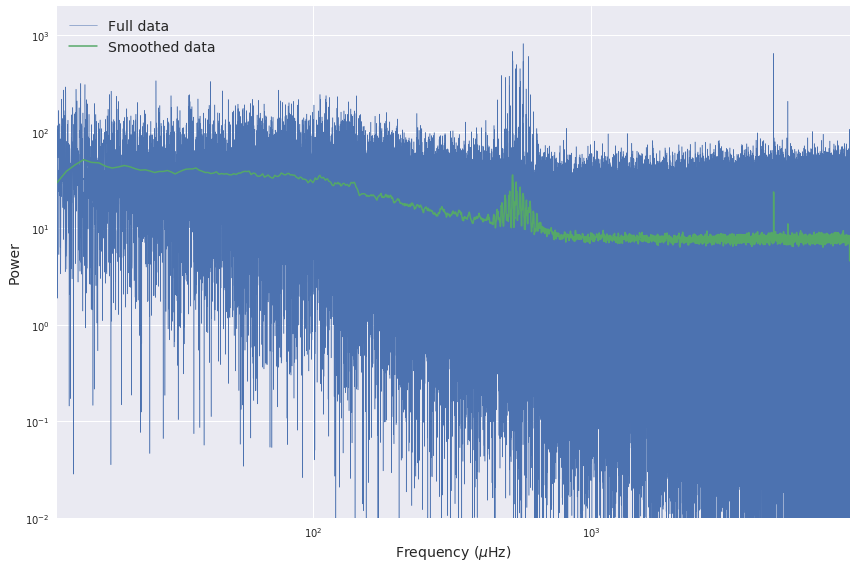

In [113]:
plt.loglog(full_freq, power, lw=.5, alpha=1, c='C0')
plt.loglog(freq, itrp_power, 'C1', lw=1.5)
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout();
plt.legend(['Full data', 'Smoothed data'])
plt.savefig('figs/psd_pre.pdf')

In [115]:
v_nyq = 8496.36
R_v = (np.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
k = 3
with pm.Model() as max_model:
    W = pm.Bound(pm.Normal, lower=0)('W', mu=12, sd=5)
    a = pm.Normal('a', mu=np.array([59, 67, 76]).reshape(k,1), sd=20, shape=(k,1))
    b = pm.Normal('b', mu=np.array([5, 150, 400]).reshape(k,1), sd=np.array([10, 50, 100]).reshape(k,1), shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4), axis=0)
    
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=17, sd=1)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=568, sd=5)
    s = pm.Cauchy('s', 55, 10)
    
    env = pm.Normal.dist(mu=v_max, sd=s).logp(freq)
    like = W + R_v * (harv + H0**2 * pm.math.exp(env))
    e = pm.HalfCauchy('e', 10)
    y = pm.Normal('obs', mu=like, sd=e, observed=itrp_power)
    

In [117]:
with max_model:
    trace = pm.sample(3000, tune=1000, njobs=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [e_log__, s, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
100%|██████████| 4000/4000 [04:42<00:00, 14.18it/s]
The acceptance probability does not match the target. It is 0.9020247499068291, but should be close to 0.8. Try to increase the number of tuning steps.


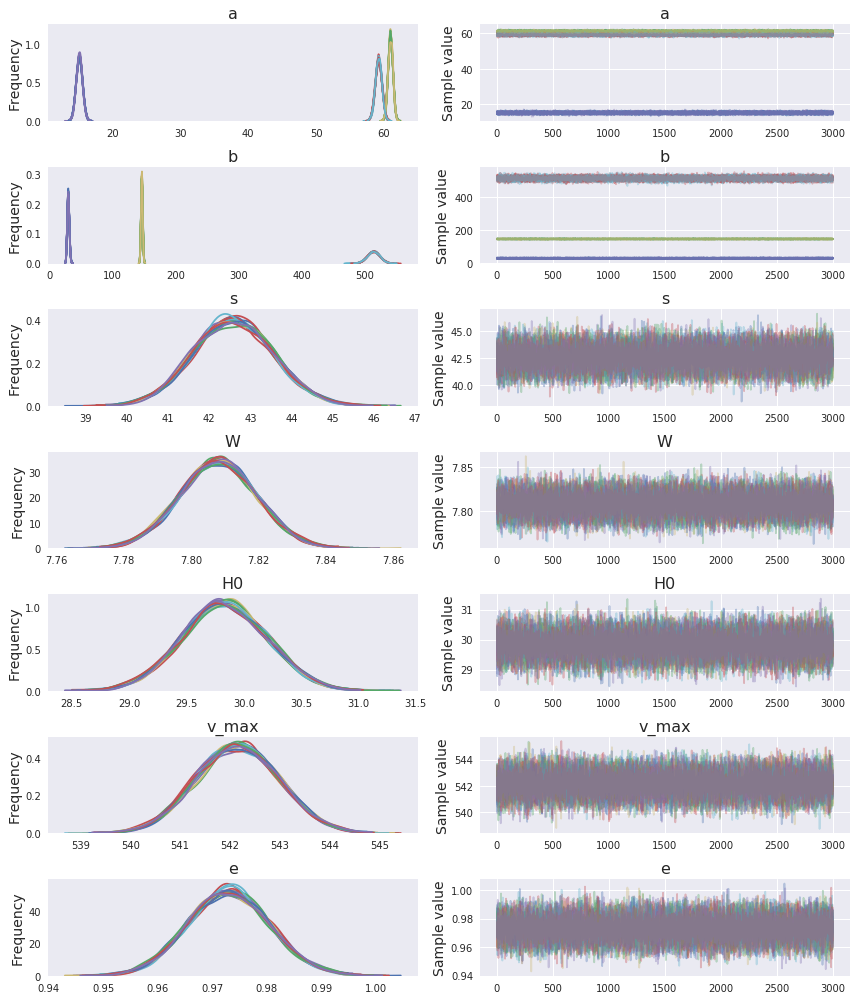

In [118]:
pm.traceplot(trace);
plt.savefig('figs/trace1.pdf')

In [119]:
summ = pm.summary(trace)
summ.to_csv('trace_summary.csv')
summ

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0_0,15.147253,0.468023,0.002423,14.218605,16.056099,41402.0,1.000008
a__1_0,60.966274,0.357188,0.002122,60.261341,61.662113,32549.0,1.000016
a__2_0,59.218296,0.487178,0.002801,58.288288,60.202038,33702.0,1.000106
b__0_0,29.768646,1.665490,0.008456,26.592037,33.091190,44216.0,1.000010
b__1_0,146.553955,1.355166,0.008383,143.864243,149.170990,30622.0,1.000044
b__2_0,514.735107,9.874024,0.057205,495.300232,534.022339,31359.0,1.000009
s,42.583595,0.964743,0.004884,40.688705,44.472137,36553.0,0.999994
W,7.808112,0.011399,0.000051,7.785945,7.830565,48000.0,1.000009
H0,29.829527,0.370994,0.001931,29.118811,30.568491,32387.0,0.999975
v_max,542.145813,0.830575,0.004284,540.490540,543.729004,48000.0,1.000108


In [120]:
ppc = pm.sample_ppc(trace, 1000, max_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 725.11it/s]


In [122]:
def harvey(v, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)

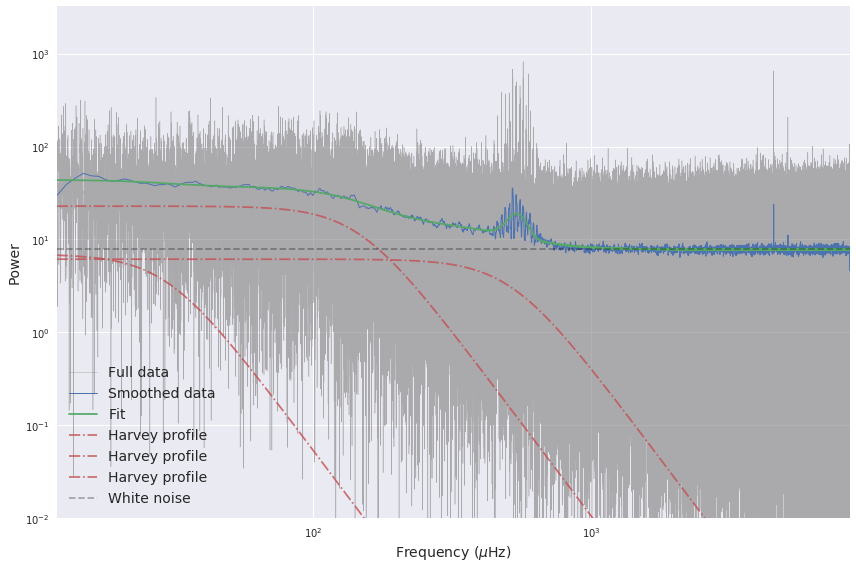

In [125]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5', label='Full data')
plt.loglog(freq, itrp_power, 'C0', lw=1, label='Smoothed data')
plt.loglog(freq, post, 'C1', label='Fit')
# plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace.get_values('a').mean(axis=0)
b = trace.get_values('b').mean(axis=0)
[plt.loglog(freq, harv, 'C2-.', alpha=.8, label='Harvey profile') for harv in harvey(freq, a, b)]
plt.axhline(trace.get_values('W').mean(), c='k', alpha=.3, ls='--', label='White noise')
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
h, l = pl
plt.legend()
plt.savefig('figs/psd_fit.pdf')

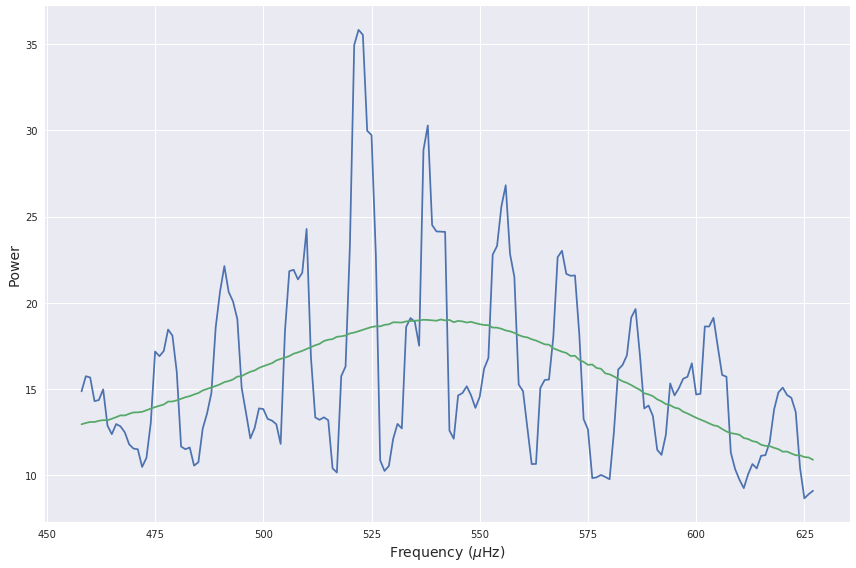

In [134]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
m = (freq > (v_max - 2 * s)) & (freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(freq[m], itrp_power[m])
plt.plot(freq[m], post[m])
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend(['Smoothed data', 'Envelope'])
plt.savefig('figs/env_fit.pdf')

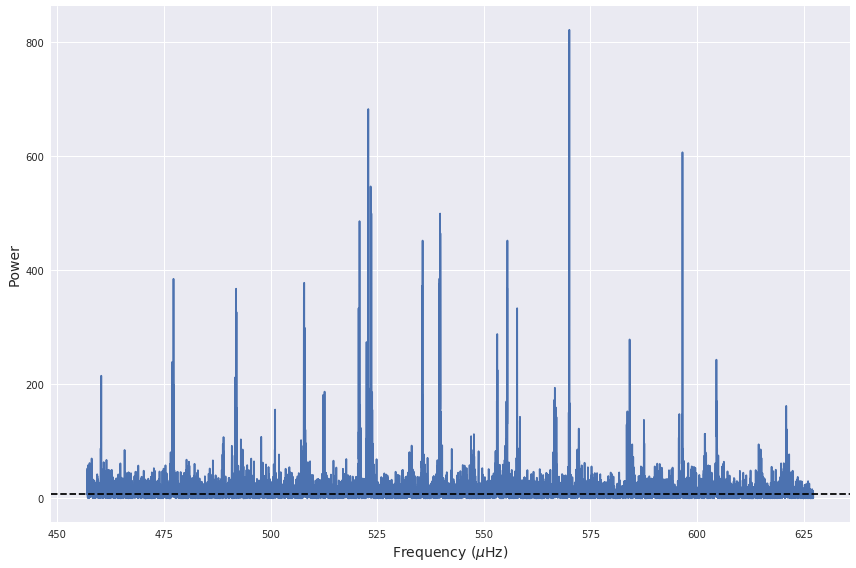

In [136]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(subfreq, subpower)
plt.axhline(trace.get_values('W').mean(), c='k', ls='--')
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/env.pdf')

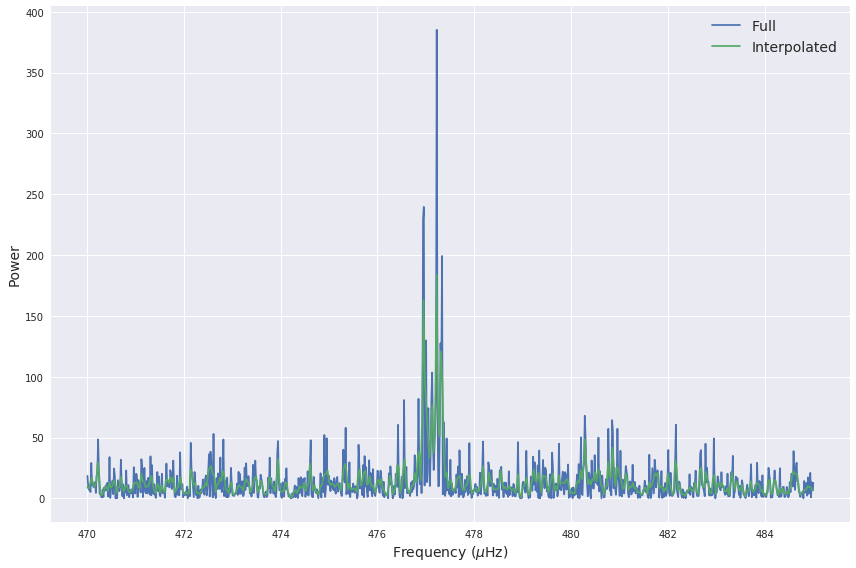

In [93]:
mask = (full_freq > 470) & (full_freq < 485)
ff = full_freq[mask]
pp = power[mask]

fstep = ff[1]-ff[0]
subfreq = np.linspace(min(ff), max(ff), 500)
smp = cv.convolve(pp, cv.Box1DKernel(3))
subpower = np.interp(subfreq, ff, smp)
modes = np.array([477.15])
# print(subpower.shape)
plt.plot(ff, pp, label='Full')
plt.plot(subfreq, subpower, label='Interpolated')
# plt.axhline(trace.get_values('W').mean(axis=0), ls='--', c='k')
# [plt.axvline(m, c='.6') for m in modes]
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend()
plt.savefig('figs/subenv.pdf')

In [105]:
import theano.tensor as tt
n = len(modes)
v_nyq = 8496.36
R_v = (np.sin( np.pi * subfreq / (2 * v_nyq)) / ((np.pi * subfreq) / (2 * v_nyq)))**2

with pm.Model() as mode_model:
    A = pm.Bound(pm.Normal, lower=2)('A', mu=20, sd=10)
    v0 = pm.Normal('v0', mu=477, sd=2,)
#     L = pm.Bound(pm.Normal, lower=0.1)('L', mu=.15, sd=1, shape=(n,1))
    L = pm.Bound(pm.HalfCauchy, lower=0, upper=20)('L', beta=2,)
#     nu = pm.Normal('nu', 0, sd=1)
    
    e = pm.HalfCauchy('e', 20)
    
#     envs = (A**2 / (np.pi * L)) / (1 + 4 * ( subfreq - (v0))**2 / L**2)
    env = A**2 * pm.math.exp(pm.Cauchy.dist(alpha=v0, beta=L).logp(subfreq))
    like = R_v * env + 7.808
    
    y = pm.Normal('obs', mu=like, sd=e, observed=subpower)

INFO (theano.gof.compilelock): Refreshing lock /home/ec2-user/.theano/compiledir_Linux-4.9-amzn1.x86_64-x86_64-with-glibc2.9-x86_64-3.6.4-64/lock_dir/lock


In [106]:
with mode_model:
    mode_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, L_interval__, v0, A_lowerbound__]
100%|██████████| 3000/3000 [00:06<00:00, 477.72it/s]


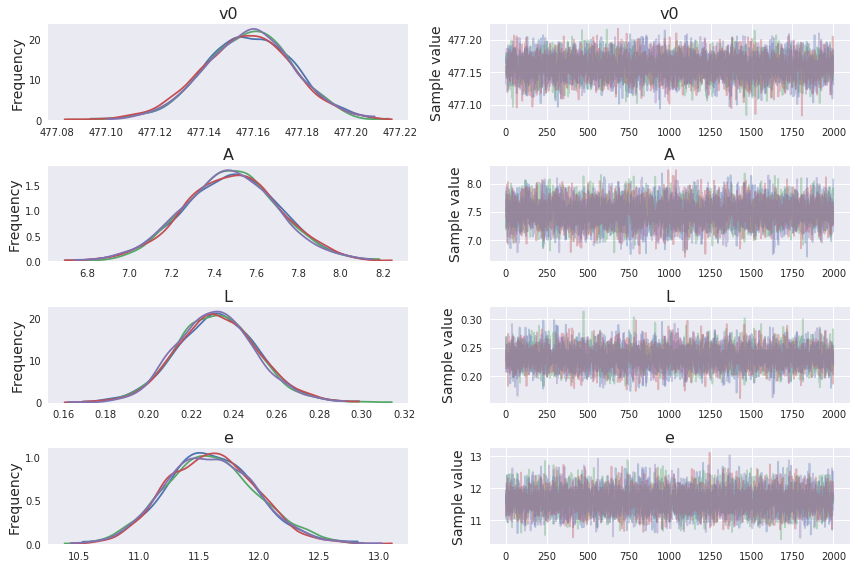

In [107]:
pm.traceplot(mode_trace);
plt.savefig('figs/mode_trace.pdf')

In [108]:
prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:03<00:00, 280.86it/s]


In [109]:
mode_summ = pm.summary(mode_trace)
mode_summ.to_csv('mode_summ.csv')
mode_summ

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
v0,477.158020,0.018170,0.000255,477.123444,477.194519,5695.0,1.000505
A,7.480131,0.223725,0.003145,7.057245,7.937908,5167.0,1.000058
L,0.232010,0.018720,0.000276,0.194819,0.268420,4981.0,1.000238
e,11.605309,0.369980,0.004396,10.907512,12.344864,7243.0,0.999794


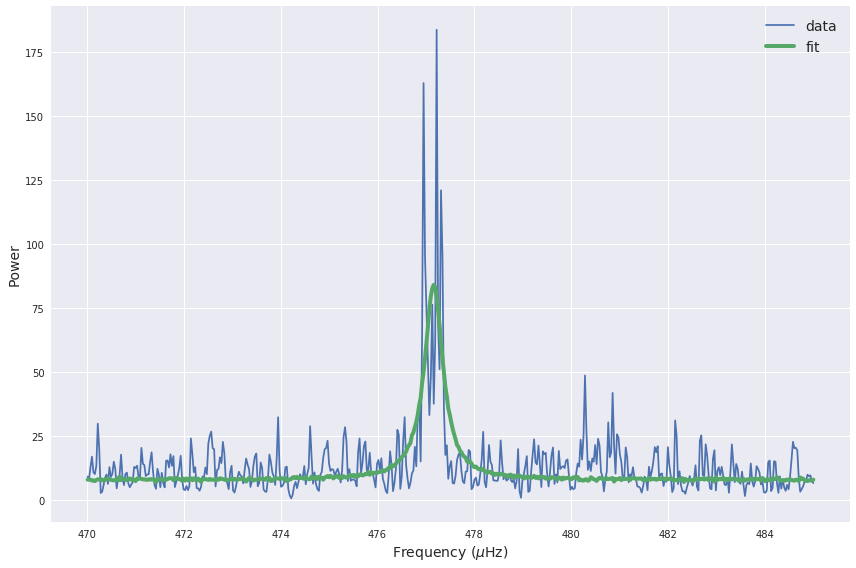

In [112]:
plt.plot(subfreq, subpower)
plt.plot(subfreq, prof, 'C1', lw=4)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend(['data', 'fit'])
plt.savefig('figs/mode_fit.pdf')

In [141]:


output = mystdout.getvalue().split('\n')
print(output[-100:])

In [142]:
output

['A __str__ = [[1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]]',
 'v0 __str__ = [[520.]',
 ' [523.]',
 ' [533.]',
 ' [536.]',
 ' [540.]]',
 'L __str__ = [[1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]]',
 'y __str__ = [7.81314988 7.81326504 7.81338467 7.81350902 7.81363836 7.81377295',
 ' 7.81391312 7.81405917 7.81421146 7.81437035 7.81453627 7.81470963',
 ' 7.81489092 7.81508064 7.81527934 7.81548762 7.81570613 7.81593557',
 ' 7.81617672 7.81643042 7.81669757 7.8169792  7.81727638 7.81759034',
 ' 7.8179224  7.81827402 7.81864682 7.8190426  7.81946333 7.81991122',
 ' 7.82038872 7.82089857 7.82144385 7.82202799 7.82265486 7.82332883',
 ' 7.82405483 7.82483847 7.82568611 7.82660504 7.82760358 7.82869131',
 ' 7.82987928 7.83118027 7.83260915 7.83418326 7.83592292 7.83785203',
 ' 7.83999887 7.84239696 7.84508632 7.84811484 7.85154014 7.85543184',
 ' 7.85987431 7.86497016 7.87084441 7.87764944 7.8855706  7.89483192',
 ' 7.90570089 7.91848968 7.93354785 7.95123735 7.97187418 7.99561337',
 ' 8.02